# 混合指数分布を実装する

### インポートモジュール

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

## 1.まず指数分布について

指数分布の確率密度関数は、
$$
f(x) = \lambda exp(-\lambda x)
$$

であり、N個のサンプルの対数尤度関数は、
$$
\begin{align}
l(\lambda|x) &= \sum_{i = 1}^{N}\log(\lambda \exp(-\lambda x_i)) \\
&=n\log\lambda - \lambda \sum_{i = 1}^{N}x_j
\end{align}
$$

よって最尤推定量は、
$$
\hat{\lambda}^{MLE} = \frac{N}{\sum_{i = 1}^{N}x_i}
$$

### 実装

In [17]:
class ExpDistribution:
    def __init__(self):
        self.param_la = np.random.rand(1)
    
    # DensityFunction
    def PDF(self,x):
        return self.param_la * np.exp(-1 * self.param_la * x)
    
    # MaximumLikelihoodEstimation
    def MLEfit(self,x):
        self.param_la = len(x) / np.sum(x)
        return self.param_la
    
    def set_lambda(self,param_la):
        self.param_la = param_la


## 2.ポアソン過程をシミュレーションしてみる

一定確率で起こるイベントが、発生するまでの時間をシミュレーションする。
ただし、観測の右側打ち切りは無いものとする。

In [4]:
# 確率一定でランダムに起きる事象をシミュレーション
def rand_event(size_N = 5000,event_p = 0.05):
    x = np.zeros(size_N)
    j = 0
    # 今回は観測打ち切りはない
    #for j in range(int(1/event_p) *100):
    while np.any(x == 0):
        j += 1
        # 遅いのでnumpy使う
#         for i in range(size):
#             if (np.random.binomial(n = 1,p = event_p) == 1) & (x[i] == 0):
#                 x[i] = j
        y = np.random.binomial(n = 1,p = event_p,size = size_N)*j
    
        x = np.where((y != 0) & (x ==0),y,x)

    return x

In [21]:
np.random.seed(0)
y = rand_event(size_N = 100000,event_p=0.05)

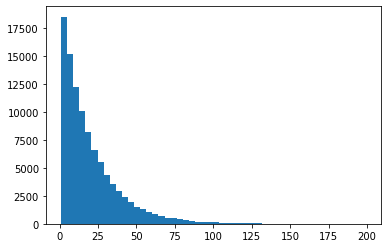

In [22]:
plt.hist(y,bins = 50)
plt.show()

In [23]:
# 連続した整数
x = np.arange(np.max(y))
Exp_object = ExpDistribution()

## シミュレートしたデータに対して、指数分布をfitting

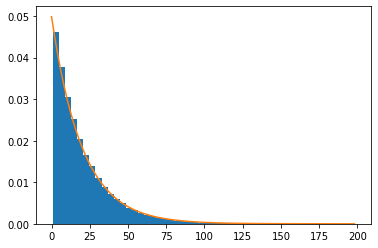

0.04984537963238036

In [88]:
# パラメーターを最尤推定値で更新
weights = np.ones(len(y))/float(len(y))
Exp_object.MLEfit(y)
plt.hist(y,bins = 50,weights = weights/4)
plt.plot(Exp_object.PDF(x))
#plt.hist(x,bins = 50,normed = True)
plt.show()
Exp_object.param_la

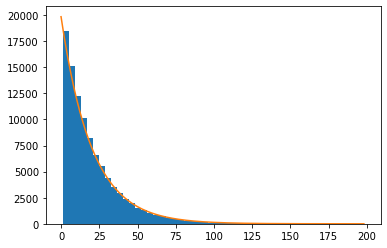

In [25]:
size_N = 100000
bins_num = 50
dt = np.max(y) / bins_num
plt.hist(y,bins = bins_num)
plt.plot(Exp_object.PDF(x) * size_N *dt)
plt.show()

フィットしている

# 2.混合指数モデル

## 利点

あるイベント(ポアソン過程に従う)についての発生確率が異なる集団に対して、一つの確率分布で表現できる。<br>
イベントが発生するまでの時間に関してのデータのみが観測できたとき、そのデータを使って、クラスタを特定(ただし、確率的)できる。

## 初期状態

In [27]:
K = 2
sample_size_1 = 200000
sample_size_2 = 100000

In [28]:
np.random.seed(0)
time_1 = rand_event(size_N = sample_size_1,event_p=0.05)
time_2 = rand_event(size_N = sample_size_2,event_p=0.2)
time_1and2 = np.hstack((time_1,time_2))

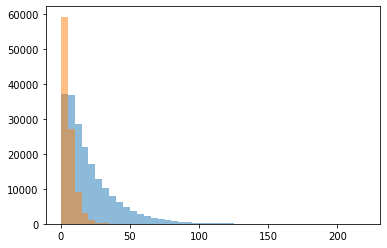

In [29]:
max_time_1and2 = np.max(time_1and2).astype(int)
bins_1and2 = range(0,max_time_1and2,5)

#plt.hist((time_1,time_2),bins = 100)
plt.hist(time_1,bins = bins_1and2,alpha = 0.5)
plt.hist(time_2,bins = bins_1and2,alpha = 0.5)
plt.show()

どちらのクラスかわからずに観測されている場合は、下図のようになる。

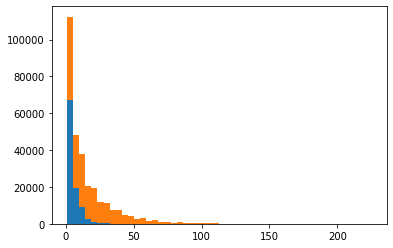

In [30]:
plt.hist((time_2,time_1),stacked = True,bins = 50)
plt.show()

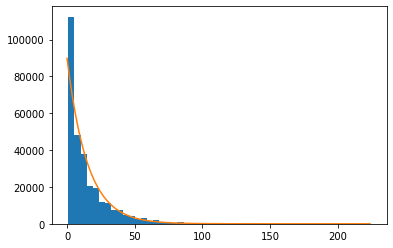

In [31]:
# パラメーターを最尤推定値で更新
Exp_object.MLEfit(time_1and2)
#plt.plot(Exp_object.PDF(y)*1000)
size_N = sample_size_1 + sample_size_2
bins_num = 50
dt = np.max(time_1and2) / bins_num
x_dist = np.arange(np.max(time_1and2))

plt.hist(time_1and2,bins = bins_num)
plt.plot(Exp_object.PDF(x_dist) * size_N *dt)
plt.show()

この場合、うまくフィットできていない

## 本題 : 混合指数分布について

### 確率密度関数

$\lambda = (\lambda_1,\lambda_2,\cdots,\lambda_k)$ , $\lambda_i > 0$,<br>
$\pi = (\pi_1,\pi_2,\cdots,\pi_k)$ , $0<\pi_i<1$ , $\sum_{k = 1}^{K}\pi_k = 1 $を満たすとする。<br>
pdfは、
$$
f(x|\pi,\lambda) = \sum_{k = 1}^{K}\pi_k \lambda_k exp(-\lambda_k x)
$$



### 混合指数分布の最尤推定

最適化問題は、
$$
\max_{\lambda,\pi} \left[\sum_{n=1}^{N}\log{\sum_{k = 1}^{K}\pi_k \lambda_k exp(-\lambda_k x)}\right]　\\
s.t. \sum_{k = 0}^{K}\pi_{k} = 1
$$

対数尤度関数の下界を最大化する式に変形すると、

$$
\max_{Q}\left[
\sum_{n = 1}^{N}\sum_{k = 1}^{K}Q_{nk}(\log{\pi_k} + 
\log{\lambda_k} -\lambda_k x -\log{Q_{nk}})
\right]\\
s.t. \sum_{k = 1}^{K}Q_{nk} = 1
$$

これを解き、
$$
Q_{nk} = \frac{\pi_k\lambda_k\exp(-\lambda_k x_n)}
{\sum_{k'= 1}^{K}\pi_{k'}\lambda_{k'}\exp(-\lambda_{k'}x_n)}
$$

この$Q_{nk}$を使って、$\lambda,\pi$を推定する
$$
\begin{align}
\lambda_k &= \frac{\sum_{n = 1}^{N}Q_{nk}}{\sum_{n' = 
1}^{N}Q_{n'k}x_{n'}} \\
\pi_k &= \frac{\sum_{n = 1}^{N}Q_{nk}}{\sum_{n' = 
1}^{N}\sum_{k' = 1}^{K} Q_{n'k'}}
\end{align}
$$

### 実装

In [68]:
class ExpMixModel:
    def __init__(self,num_components = 2):
        self.num_components = num_components
        self.ExpDist_list = []
        self.weight = np.ones(self.num_components) / self.num_components
        for _ in range(self.num_components):
            self.ExpDist_list.append(ExpDistribution())
        
    def e_step(self, X):
        posterior = np.zeros((X.shape[0], self.num_components))
        for each_component in range(self.num_components):
            posterior[:, each_component] \
               = self.weight[each_component] * self.ExpDist_list[each_component].PDF(X)
        posterior = posterior / posterior.sum(axis=1).reshape(-1, 1)
        return posterior
    
    def m_step(self, X, posterior):
        self.weight = posterior.sum(axis=0)
        for each_component in range(self.num_components):

            self.ExpDist_list[each_component].set_lambda( self.weight[each_component] / (posterior[:, each_component] @ X))
            
        self.weight = self.weight / np.sum(self.weight)
    
    def log_pdf(self, X):
        sample_size = X.shape[0]
        likelihood = np.zeros(sample_size) # 各データの尤度を計算する
        for each_component in range(self.num_components):
            likelihood = likelihood + self.weight[each_component] * self.ExpDist_list[each_component].PDF(X)
        # 対数尤度を返す
        return np.log(likelihood)
    
    def fit(self, X, eps=1e-8):
        sample_size = X.shape[0]
        converge = False
        old_ll = -np.inf
        new_ll = -np.inf
        while not converge:
            posterior = self.e_step(X)
            self.m_step(X, posterior)
            new_ll = self.log_pdf(X).sum()
            if new_ll < old_ll:
                raise ValueError('likelihood decreases!')
            if np.abs(old_ll - new_ll) / np.abs(new_ll) < eps:
                converge = True
            old_ll = new_ll
        return posterior

In [69]:
EMM = ExpMixModel()

### クラスタがわからない状態のデータに対して適用してみる

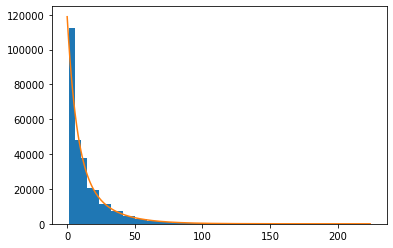

In [79]:
# パラメーターをEMアルゴリズムで更新
EMM.fit(time_1and2)
#plt.plot(Exp_object.PDF(y)*1000)
size_N = sample_size_1 + sample_size_2
bins_num = 50
dt = np.max(time_1and2) / bins_num
x_dist = np.arange(np.max(time_1and2))

plt.hist(time_1and2,bins = bins_num)
plt.plot(np.exp(EMM.log_pdf(x_dist)) * size_N *dt)
plt.show()

当てはまりはよくなった。

### 真の値と比べてみると...?

In [82]:
EMM.weight

array([0.58728204, 0.41271796])

In [84]:
for i in range(len(EMM.weight)):
    print(EMM.ExpDist_list[i].param_la)

0.048229942318727174
0.1447136488016862


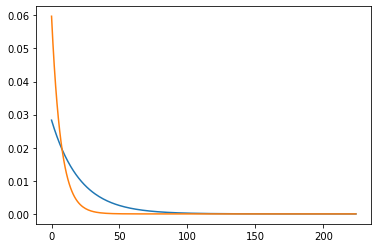

In [98]:
plt.plot(EMM.ExpDist_list[0].PDF(x_dist)*EMM.weight[0])
plt.plot(EMM.ExpDist_list[1].PDF(x_dist)*EMM.weight[1])
#plt.plot(np.exp(EMM.log_pdf(x_dist)))
plt.show()

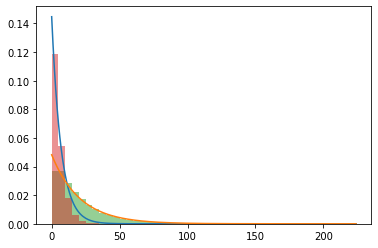

In [102]:
max_time_1and2 = np.max(time_1and2).astype(int)
bins_1and2 = range(0,max_time_1and2,5)

plt.plot(EMM.ExpDist_list[1].PDF(x_dist))
plt.plot(EMM.ExpDist_list[0].PDF(x_dist)) #*EMM.weight[0]

#hist
plt.hist(time_1,bins = bins_1and2,alpha = 0.5,density = True)
plt.hist(time_2,bins = bins_1and2,alpha = 0.5,density = True)

plt.show()

いいかんじだで

## 考察

クラスタの数がわかっていればある程度は推定できそう。